# Intro to Statistical Analysis with Python

In the first notebook, we used `numpy`, `scipy`, and `matplotlib` to visualize the output of mathematical functions. For the next couple of weeks, we will explore the use of python tools to analyze experimental data. Specifically, this week we will focus on visualizing experimental data and performing some basic statistical analysis. Python's statistics capabilities are not quite as fully-featured as the `R` language (though if you need it, the [`rpy2` package](https://pypi.org/project/rpy2/) provides a python interface to `R`), but are extensive enough for most scientific applications.

This notebook uses data from the 2017-2018 [National Health and Nutrition Examination Survey](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017), and assumes that the following data files are available in the current working directory (by default, the same directory as the notebook file).

- Standard Biochemistry Profile [BIOPRO_J.XPT](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BIOPRO_J.XPT)
- Demographic Variables and Sample Weights [DEMO_J.XPT](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT)
- Body Measures [BMX_J.XPT](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BMX_J.XPT)
- Dietary Interview, Total Nutrient Intakes, First Day [DR1TOT_J.XPT](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DR1TOT_J.XPT)
- Blood Pressure [BPX_J](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BPX_J.XPT)

## Introduction to `pandas`

The [`pandas` package](https://pandas.pydata.org/), which is part of the SciPy ecosystem, is one of the most widely-used packages when working with most types of experimental data. The package provides two useful data structures:

- [`pandas.Series`](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) is essentially a 1D `numpy.ndarray` with extra features: it allows each entry to have an arbitrary label rather then just an integer index starting from 0. Like `numpy.ndarray` objects, a `pandas.Series` object has a fixed length, and all of the entries must be of the same type. These could be floats, ints, strings, or other types. In nearly all cases, a function that works on a `numpy.ndarray` will also work exactly the same on 
- [`pandas.Dataframe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) represents a 2D table of data, where each row and column may be labeled. Essentially, it is a table in which each column is a `pandas.Series` object. The columns do not all need to be the same length or of the same type, and the number of columns can be changed at any time. The data in the table are aligned by the labels for each `pandas.Series` object. This is a very powerful feature that is discussed in a bit more detail below.

It is strongly recommended that you read over the `pandas` [Intro to Data Structures](https://pandas.pydata.org/docs/getting_started/dsintro.html) article and [10 Minutes to `pandas`](https://pandas.pydata.org/docs/getting_started/10min.html) to get a sense for what these structures are capable of. In this notebook we will only have the chance to highlight a few features. Before we dive into real data, let's take a look at a simple example to illustrate how these data structures work.

Our example will be a simple gradebook for a class of 5 students with a few assignments. We'll first create a `pandas.Series` object containing the students' names, using their student ID numbers as the "index."


In [1]:
import numpy as np
import pandas as pd

students = pd.Series(['Alice', 'Bob', 'Charlie', 'Diane', 'Elaine'],index=[421,398,990,102,556],name="Student Name")

students

421      Alice
398        Bob
990    Charlie
102      Diane
556     Elaine
Name: Student Name, dtype: object

The data contained in the array are the students' names. We also told `pandas` to use student ID numbers as the index for each row: Alice has a student ID number of 421, and so on. Finally, we told `pandas` the name of the data array. When we inspect the `Series` object, we see that each student is listed with their corresponding student ID number. We can use that ID number as an index to access the student.

In [2]:
print(students[421],students[556])

Alice Elaine


We'll now initialize the gradebook, giving it the `students` object we created before. When we inspect the gradebook, `pandas` outputs a nicely formatted table with the column heading corresponding to the name we gave the `Series` object. We can use that column heading to access data contained in the column.

In [3]:
gradebook = pd.DataFrame(students)

print(gradebook['Student Name'][990])

gradebook

Charlie


,Student Name
421,Alice
398,Bob
990,Charlie
102,Diane
556,Elaine


Alternatively, `pandas.Dataframe` provides another syntax for accessing elements: the [`at`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html), [`loc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html), [`iat`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iat.html#pandas.DataFrame.iat), and [`iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) functions.

In [4]:
gradebook.iat[1,0]

'Bob'

In [5]:
gradebook.iloc[1:4]

,Student Name
398,Bob
990,Charlie
102,Diane


In [6]:
gradebook.at[102,'Student Name']

'Diane'

In [7]:
gradebook.loc[:,'Student Name']

421      Alice
398        Bob
990    Charlie
102      Diane
556     Elaine
Name: Student Name, dtype: object

There are many ways to add new columns to a `Dataframe`, and we'll look at a couple different ones here. Let's assume the students turn in their first assignment, and you have graded it. One way is to create a `pandas.Series` object exactly as before and use the [`Dataframe.join`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) function:

In [8]:
hw1 = pd.Series([100,95,70,89,65],index=[421,398,990,102,556],name='HW1')
gradebook.join(hw1)

,Student Name,HW1
421,Alice,100
398,Bob,95
990,Charlie,70
102,Diane,89
556,Elaine,65


Note that by default, `pandas` functions **do not modify** the dataframe(s) they're called on. So even though we joined `hw1` to `gradebook`, `gradebook` itself remains unchanged:

In [9]:
gradebook

,Student Name
421,Alice
398,Bob
990,Charlie
102,Diane
556,Elaine


If you want to keep the merged version, simply assign the result to a new variable (or overwrite `gradebook` if desired as we will do below after a couple more examples). Here we'll show a different method for adding the column: using a python dictionary whose keys are the student ID numbers and whose values are the grades. Notice that the order of the grades in the dictionary doesn't matter; each grade is associated with the student ID number, not its position in the dictionary. The dictionary is passed to the `pandas.Series` constructor, and then we use [`Dataframe.assign`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html) to add the column and its column heading.

In [10]:
hw1_dict = {
    421: 100,
    102: 89,
    398: 95,
    990: 70,
    556: 65
}
gradebook.assign(HW1=pd.Series(hw1_dict))

,Student Name,HW1
421,Alice,100
398,Bob,95
990,Charlie,70
102,Diane,89
556,Elaine,65


Like the `join` function, this method does not modify the gradebook. 

In [11]:
gradebook

,Student Name
421,Alice
398,Bob
990,Charlie
102,Diane
556,Elaine


Now let's say that we have the following grades for HW2 and HW3: only 3 students turned in HW2, and only 4 turned in HW 3. We can add all three dictionaries with a single `assign` call. Here we overwrite the original gradebook with the modified version created by the `assign` function.

In [12]:
gradebook = gradebook.assign(HW1 = pd.Series(hw1_dict),
                             HW2 = pd.Series( {421:100,102:88,556:95} ),
                             HW3 = pd.Series( {421:99,990:45,102:76,556:90}))

gradebook

,Student Name,HW1,HW2,HW3
421,Alice,100,100.0,99.0
398,Bob,95,NaN,NaN
990,Charlie,70,NaN,45.0
102,Diane,89,88.0,76.0
556,Elaine,65,95.0,90.0


In `pandas`, missing data are treated as `NaN` (not a number) by default. Many `pandas` functions also allow you to specify a default value that replaces `NaN`, so in a gradebook you might consider setting the default grade as 0. We won't do that here, because the way `pandas` treats `NaN` values is convenient.

We can get a summary of the data in the `gradebook` by using the [`Dataframe.describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function. By default, `pandas` functions **ignore** `NaN` values. You can see this in the `count` row.

In [13]:
gradebook.describe()

,HW1,HW2,HW3
count,5.000000,3.000000,4.000000
mean,83.800000,94.333333,77.500000
std,15.482248,6.027714,23.643181
min,65.000000,88.000000,45.000000
25%,70.000000,91.500000,68.250000
50%,89.000000,95.000000,83.000000
75%,95.000000,97.500000,92.250000
max,100.000000,100.000000,99.000000


Now, let's say we want to add columns for the total homework points and the homework percentage. We can do that directly from `Dataframe.assign` because we can reference existing columns. The operation uses broadcasting very much like a `numpy.ndarray` to perform a calculation on all rows of the column. Both `pandas.Series` and `pandas.Dataframe` also have methods like `add`, `sub`, `mul`, `div`, `pow`, `sum` and so on which are better to use than `+`, `-`, `*` etc., because they allow you to control how `NaNs` are treated explicitly if you wish. So to calculate the sum of the three homework assignments, we can use the `loc` command to select the three columns we want, and call the [`sum`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html) function. The `axis=1` tells the sum operation to add across the columns.

In [14]:
gradebook.assign(HWTotal = gradebook.loc[:,['HW1','HW2','HW3']].sum(axis=1))

,Student Name,HW1,HW2,HW3,HWTotal
421,Alice,100,100.0,99.0,299.0
398,Bob,95,NaN,NaN,95.0
990,Charlie,70,NaN,45.0,115.0
102,Diane,89,88.0,76.0,253.0
556,Elaine,65,95.0,90.0,250.0


The following does not work: when using the `+` operator, any `NaN` values will cause the result to be `NaN`.

In [15]:
gradebook.assign(HWTotal = gradebook.HW1 + gradebook.HW2 + gradebook.HW3)

,Student Name,HW1,HW2,HW3,HWTotal
421,Alice,100,100.0,99.0,299.0
398,Bob,95,NaN,NaN,NaN
990,Charlie,70,NaN,45.0,NaN
102,Diane,89,88.0,76.0,253.0
556,Elaine,65,95.0,90.0,250.0


Let's add columns for HWTotal and HWPct.

In [16]:
hwtotal = gradebook.loc[:,['HW1','HW2','HW3']].sum(axis=1)
hwpct = hwtotal/3.
gradebook = gradebook.assign(HWTotal = hwtotal,HWPct = hwpct)
gradebook

,Student Name,HW1,HW2,HW3,HWTotal,HWPct
421,Alice,100,100.0,99.0,299.0,99.666667
398,Bob,95,NaN,NaN,95.0,31.666667
990,Charlie,70,NaN,45.0,115.0,38.333333
102,Diane,89,88.0,76.0,253.0,84.333333
556,Elaine,65,95.0,90.0,250.0,83.333333


If now Bob hands in HW3 late and gets 50 points, we can modify the gradebook:

In [17]:
gradebook.at[398,'HW3'] = 50
gradebook

,Student Name,HW1,HW2,HW3,HWTotal,HWPct
421,Alice,100,100.0,99.0,299.0,99.666667
398,Bob,95,NaN,50.0,95.0,31.666667
990,Charlie,70,NaN,45.0,115.0,38.333333
102,Diane,89,88.0,76.0,253.0,84.333333
556,Elaine,65,95.0,90.0,250.0,83.333333


This highlights one key difference between `Dataframes` and spreadsheets: the `HWTotal` and `HWPct` columns were not modified when we changed the data in the table. All of the columns are independent of one another. A `Dataframe` is designed to store values, not formulas. So if you need to update other columns, you must recalculate them. In pactice, `Dataframe` objects usually don't contain columns that depend on other columns like this. Normally only the raw data (homework scores, exam scores, etc) would be stored in a `Dataframe`, and then calculations would be performed as needed.

## Creating `Dataframe` from real data and data inspection

The `pandas` package comes with a number of utilities for loading dataframes from common file formats, including csv, xlsx, json, hdf5, and others. The data from the NHANES servey are written in the SAS Transport File Format xpt, and `pandas` has a built-in routine called [`pandas.read_sas`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sas.html) which can handle this format. Let's begin with [BIOPRO_J.XPT](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BIOPRO_J.XPT).

In [18]:
bio = pd.read_sas('BIOPRO_J.XPT',index='SEQN') # Use the 'SEQN' field as the index... more on this below
print([len(bio[col]) for col in bio.columns]) #print number of entries in each column
bio.head(10) # print the first 10 rows

[6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401, 6401]


,LBXSATSI,LBDSATLC,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,LBXSC3SI,LBXSBU,LBDSBUSI,LBXSCLSI,...,LBXSCA,LBDSCASI,LBXSCH,LBDSCHSI,LBXSTP,LBDSTPSI,LBXSTR,LBDSTRSI,LBXSUA,LBDSUASI
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,16.0,5.397605e-79,4.4,44.0,74.0,20.0,31.0,11.0,3.93,100.0,...,9.2,2.300,157.0,4.060,7.3,73.0,95.0,1.073,5.8,345.0
93706.0,10.0,5.397605e-79,4.4,44.0,79.0,14.0,28.0,12.0,4.28,104.0,...,9.6,2.400,149.0,3.853,7.1,71.0,92.0,1.039,8.0,475.8
93707.0,13.0,5.397605e-79,5.2,52.0,238.0,24.0,22.0,17.0,6.07,97.0,...,10.1,2.525,199.0,5.146,8.0,80.0,110.0,1.242,5.5,327.1
93708.0,19.0,5.397605e-79,3.9,39.0,66.0,21.0,27.0,16.0,5.71,104.0,...,9.5,2.375,210.0,5.431,7.1,71.0,72.0,0.813,4.5,267.7
93709.0,15.0,5.397605e-79,3.7,37.0,86.0,17.0,24.0,20.0,7.14,100.0,...,9.9,2.475,180.0,4.655,7.0,70.0,132.0,1.490,6.2,368.8
93711.0,20.0,5.397605e-79,4.0,40.0,56.0,23.0,29.0,14.0,5.00,102.0,...,9.4,2.350,239.0,6.181,7.1,71.0,59.0,0.666,4.2,249.8
93712.0,46.0,5.397605e-79,4.8,48.0,99.0,35.0,31.0,14.0,5.00,98.0,...,9.6,2.400,185.0,4.784,8.1,81.0,124.0,1.400,5.8,345.0
93713.0,18.0,5.397605e-79,4.3,43.0,109.0,18.0,25.0,22.0,7.85,101.0,...,9.4,2.350,188.0,4.862,6.4,64.0,95.0,1.073,5.7,339.0
93714.0,22.0,5.397605e-79,3.4,34.0,72.0,16.0,32.0,11.0,3.93,100.0,...,9.1,2.275,232.0,6.000,7.0,70.0,115.0,1.298,6.5,386.6


The meanings of the data columns are given in the [BIOPRO_J documentation](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BIOPRO_J.htm), where we can see that `SEQN` is the identifier associatied with a person in the study. This is why the code above uses that field as the index for the rows. When we look at the other data sets, the same `SEQN` value corresponds to the same study subject, so we can track that individual's data across the different datasets. All of the other column headings and their meanings are explained at that link as well. We can of course use the `Dataframe.describe` function to get basic statistics. Since this dataset has so many columns, it can be convenient to use the [`Dataframe.iloc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html) function to select a subset of the columns to display at once.

Recall that `pandas` by default ignores `NaN` values when performing calculations. When the describe the table, we can see that although there are 6401 rows in each column, there are only ~5900 values in each that are not `NaN`, though it varies per column.

In [19]:
bio.describe()

,LBXSATSI,LBDSATLC,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,LBXSC3SI,LBXSBU,LBDSBUSI,LBXSCLSI,...,LBXSCA,LBDSCASI,LBXSCH,LBDSCHSI,LBXSTP,LBDSTPSI,LBXSTR,LBDSTRSI,LBXSUA,LBDSUASI
count,5902.000000,5.902000e+03,5905.000000,5905.000000,5903.000000,5882.000000,5901.000000,5901.000000,5901.000000,5904.000000,...,5901.000000,5901.000000,5903.000000,5903.000000,5901.000000,5901.000000,5901.000000,5901.00000,5901.000000,5901.000000
mean,21.420197,1.694341e-04,4.078645,40.786452,90.616127,21.760456,25.541434,14.615489,5.218146,101.032690,...,9.319793,2.329948,183.241741,4.738640,7.165819,71.658194,137.437553,1.55167,5.402406,321.335197
std,16.949439,1.301669e-02,0.345033,3.450328,52.392677,12.952607,2.481768,5.984281,2.136455,2.786815,...,0.372979,0.093245,41.287669,1.067702,0.435356,4.353560,109.130574,1.23208,1.480927,88.085177
min,2.000000,5.397605e-79,2.100000,21.000000,16.000000,6.000000,16.000000,2.000000,0.710000,84.000000,...,6.400000,1.600000,77.000000,1.991000,5.300000,53.000000,25.000000,0.28200,0.800000,47.600000
25%,12.000000,5.397605e-79,3.900000,39.000000,64.000000,16.000000,24.000000,11.000000,3.930000,99.000000,...,9.100000,2.275000,153.000000,3.957000,6.900000,69.000000,77.000000,0.86900,4.300000,255.800000
50%,17.000000,5.397605e-79,4.100000,41.000000,79.000000,19.000000,26.000000,14.000000,5.000000,101.000000,...,9.300000,2.325000,180.000000,4.655000,7.200000,72.000000,111.000000,1.25300,5.300000,315.200000
75%,25.000000,5.397605e-79,4.300000,43.000000,98.000000,23.000000,27.000000,17.000000,6.070000,103.000000,...,9.600000,2.400000,208.000000,5.379000,7.400000,74.000000,162.000000,1.82900,6.300000,374.700000
max,420.000000,1.000000e+00,5.400000,54.000000,638.000000,272.000000,38.000000,79.000000,28.200000,117.000000,...,11.700000,2.925000,438.000000,11.327000,10.000000,100.000000,2923.000000,33.00100,15.100000,898.100000


In [20]:
bio.iloc[:,0:10].describe()

,LBXSATSI,LBDSATLC,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,LBXSC3SI,LBXSBU,LBDSBUSI,LBXSCLSI
count,5902.000000,5.902000e+03,5905.000000,5905.000000,5903.000000,5882.000000,5901.000000,5901.000000,5901.000000,5904.000000
mean,21.420197,1.694341e-04,4.078645,40.786452,90.616127,21.760456,25.541434,14.615489,5.218146,101.032690
std,16.949439,1.301669e-02,0.345033,3.450328,52.392677,12.952607,2.481768,5.984281,2.136455,2.786815
min,2.000000,5.397605e-79,2.100000,21.000000,16.000000,6.000000,16.000000,2.000000,0.710000,84.000000
25%,12.000000,5.397605e-79,3.900000,39.000000,64.000000,16.000000,24.000000,11.000000,3.930000,99.000000
50%,17.000000,5.397605e-79,4.100000,41.000000,79.000000,19.000000,26.000000,14.000000,5.000000,101.000000
75%,25.000000,5.397605e-79,4.300000,43.000000,98.000000,23.000000,27.000000,17.000000,6.070000,103.000000
max,420.000000,1.000000e+00,5.400000,54.000000,638.000000,272.000000,38.000000,79.000000,28.200000,117.000000


In [21]:
bio.iloc[:,10:20].describe()

,LBXSCK,LBXSCR,LBDSCRSI,LBXSGB,LBDSGBSI,LBXSGL,LBDSGLSI,LBXSGTSI,LBDSGTLC,LBXSIR
count,5899.000000,5903.000000,5903.000000,5901.000000,5901.000000,5901.000000,5901.000000,5902.000000,5.902000e+03,5902.000000
mean,174.869130,0.875231,77.370408,3.087172,30.871717,100.877648,5.599644,29.689427,1.694341e-04,87.282277
std,404.328956,0.446905,39.506316,0.431289,4.312887,34.834684,1.933687,42.676982,1.301669e-02,36.622528
min,16.000000,0.250000,22.100000,1.800000,18.000000,47.000000,2.610000,2.000000,5.397605e-79,10.000000
25%,77.000000,0.680000,60.110000,2.800000,28.000000,86.000000,4.770000,13.000000,5.397605e-79,62.000000
50%,115.000000,0.820000,72.490000,3.100000,31.000000,92.000000,5.110000,19.000000,5.397605e-79,83.000000
75%,181.000000,0.980000,86.630000,3.300000,33.000000,101.000000,5.610000,30.000000,5.397605e-79,107.000000
max,16959.000000,12.740000,1126.220000,6.000000,60.000000,626.000000,34.750000,1192.000000,1.000000e+00,476.000000


When exploring a dataset like this, it is useful to visualize the data in different ways. First, let's work on visualizing the distribution of data in a particular column. First, we can use the standard `Axes.plot` function from `matplotlib.`

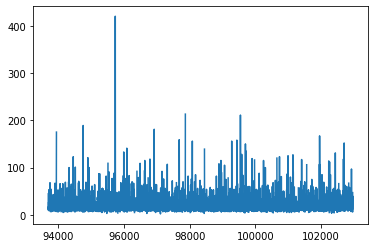

In [22]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.plot(bio.LBXSATSI)

Ths unfotunately is not a very useful way to visualize the data (though note that when we chose the column to plot, `matplotlib` automatically used the `SEQN` index on the x axis). When you want to see how the values of a dataset are distributed, it's best to use a histogram. Fortunately, histograms are very easy to make using [`Axes.hist`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.hist.html).

/home/kyle/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kyle/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


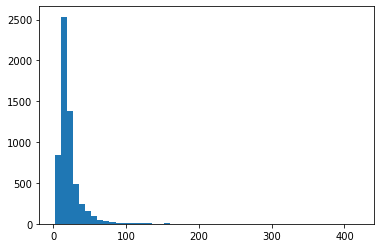

In [23]:
fig,ax = plt.subplots()
n,bins,patches = ax.hist(bio.LBXSATSI,bins=50)

This shows the number of data points that fall within a certain range of values. However, one downside to histograms is that the apearance can be rather sensitive to the chosen bin width. The plots below show what happens with 10 bins or 150 bins, each of which produces a different bin width. We're using the [`Series.dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dropna.html) function to exclude any `NaN` values from the dataset.

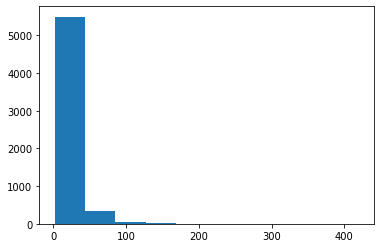

In [24]:
fig,ax = plt.subplots()
n,bins,patches = ax.hist(bio.LBXSATSI.dropna(),bins=10)

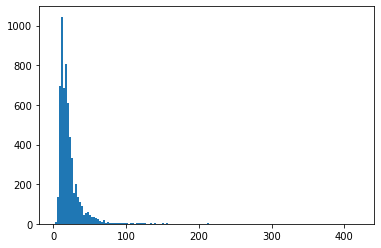

In [25]:
fig,ax = plt.subplots()
n,bins,patches = ax.hist(bio.LBXSATSI.dropna(),bins=150)

A related way to visualize the data distribution is through [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation), an implementation of which using a Gaussian kernel is available as [`scipy.stats.gaussian_kde`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html). To use this, we feed the `gaussian_kde` function the data we want to model, then create a grid of points where we want to evaluate the density. Below, we create a grid of points that runs from the minimum data value to the maximum, and give it 500 points to evaluate. The result gives a plot that has a smooth shape that follows the contour of the histograms we observed above.

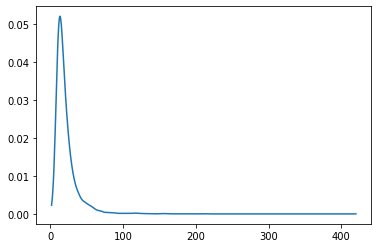

In [26]:
import scipy.stats as spstats

d = bio.LBXSATSI.dropna()
kde = spstats.gaussian_kde(d)
points = np.linspace(d.min(),d.max(),500,endpoint=True)

fig,ax = plt.subplots()
ax.plot(points,kde.evaluate(points))

The y values here are no longer the number of data points, but rather the [probability density](https://en.wikipedia.org/wiki/Probability_density_function) of finding a certain value in the dataset. The integral under the probability density curve is 1, so there is 100% probability of finding a value somewhere between the minimum value and the maximum value in the dataset, which makes sense.

We can actually use both kernel density estimates and histograms at the same time. The `Axes.hist` function takes an optional `density` argument. If set to `True`, the heights of the bars in the histogram are rescaled so that the sum of the areas of all the bars adds up to 1. This means we can plot the histogram and the kernel density estimate together.

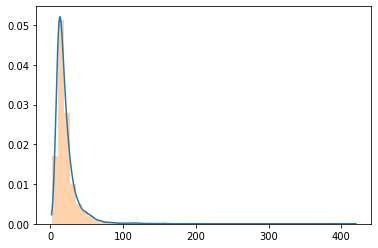

In [27]:
fig,ax = plt.subplots()
ax.plot(points,kde.evaluate(points))
n,bins,edges = ax.hist(d,bins=50,density=True,alpha=0.35)

This will be useful enough that we can write a function to generate a plot like this. Feel free to customize the appearance as you prefer.

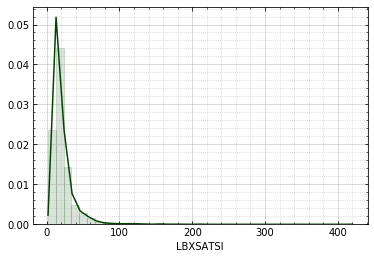

In [28]:
def make_hist_kde(ax : plt.Axes, d : pd.Series, c : str='#004400', left : bool = False):
    #customize ticks appearance
    ax.tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True)
    ax.minorticks_on()
    
    #show grid
    ax.grid(True,which='minor',linestyle=':',alpha=0.6)
    ax.grid(True,which='major',alpha=0.6)
    
    #make kde
    kde = spstats.gaussian_kde(d)
    points = np.linspace(d.min(),d.max(),len(d)//150,endpoint=True)
    if left:
        ax.plot(kde.evaluate(points),points,color=c)
        ax.hist(d,bins=len(d)//150,density=True,alpha=0.15,color=c,ec=c+'22',orientation='horizontal')
        ax.set_ylabel(d.name)
    else:
        ax.plot(points,kde.evaluate(points),color=c)
        ax.hist(d,bins=len(d)//150,density=True,alpha=0.15,color=c,ec=c+'22')
        ax.set_xlabel(d.name)
    
fig,ax = plt.subplots()
make_hist_kde(ax,bio.LBXSATSI.dropna())
    

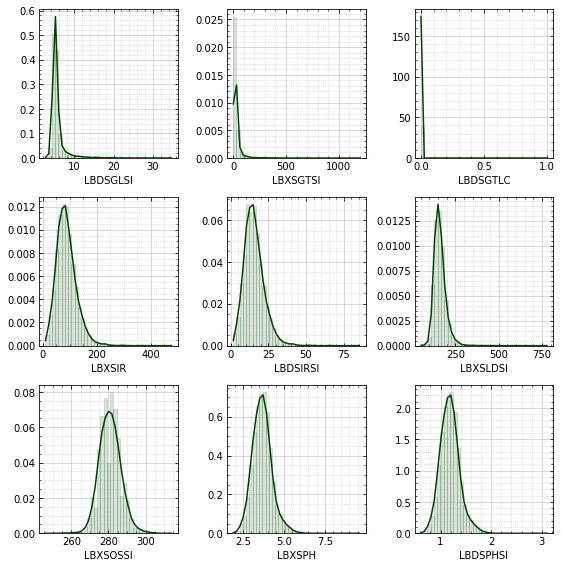

In [29]:
fig, axes = plt.subplots(3,3,figsize=(8,8))
datastart = 16
for i,ax in enumerate(axes.flatten()):
    make_hist_kde(ax,bio.iloc[:,datastart+i].dropna())
    
fig.tight_layout()

[Scatter plots](https://en.wikipedia.org/wiki/Scatter_plot) are also frequently used to look for correlations in data. The [`Axes.scatter`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html) function in `matplotlib` generates this type of plot.

Text(0, 0.5, 'LBXSLDSI')

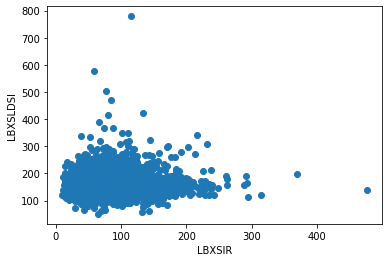

In [30]:
fig, ax = plt.subplots()

ax.scatter(bio.LBXSIR,bio.LBXSLDSI)
ax.set_xlabel(bio.LBXSIR.name)
ax.set_ylabel(bio.LBXSLDSI.name)

Often scatter plots are combined with histograms for each axis so that the distribution for each individual data set is easier to visualize. We can do this by making a 2x2 grid of plots, placing our histograms with kernel density estimates on the upper left `[0,0]` and lower right `[1,1]` plots, and the scatter plot on the lower left `[1,0]` plot. To adjust the relative plot sizes, we can use the `gridspec_kw` argument to [`pyplot.subplots`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html), which allows us to control the [`Gridspec`](https://matplotlib.org/api/_as_gen/matplotlib.gridspec.GridSpec.html) of the figure layout. We also use [`Figure.subplots_adjust`](https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.subplots_adjust) to control the width and height spacing between the subplots.

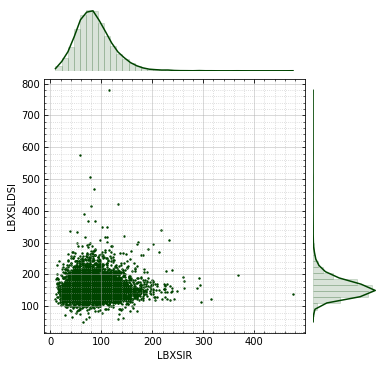

In [31]:
fig,axes = plt.subplots(2,2, figsize=(6,6), gridspec_kw={'width_ratios' : [4,1], 'height_ratios' : [1,4]})

fig.subplots_adjust(hspace=0.05,wspace=0.05)

axes[0,1].axis('off')

c = '#004400'

make_hist_kde(axes[0,0],bio.LBXSIR.dropna(),c=c)
make_hist_kde(axes[1,1],bio.LBXSLDSI.dropna(),c=c,left=True)

for ax in [axes[0,0],axes[1,1]]:
    ax.tick_params(axis='both',which='both',bottom=False,left=False,right=False,top=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    for dir in ['top','bottom','right','left']:
        ax.spines[dir].set_visible(False)


axes[1,0].scatter(bio.LBXSIR,bio.LBXSLDSI,c=c,s=2)
axes[1,0].set_xlabel(bio.LBXSIR.name)
axes[1,0].set_ylabel(bio.LBXSLDSI.name)
axes[1,0].spines['top'].set_visible(True)
axes[1,0].spines['right'].set_visible(True)
axes[1,0].tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True)
axes[1,0].minorticks_on()

#show grid
axes[1,0].grid(True,which='minor',linestyle=':',alpha=0.6)
axes[1,0].grid(True,which='major',alpha=0.6)



## Built-in `pandas` plots

Alternatively, `pandas` has convenience functions for generating many of the `matplotlib` plot types. For the most part, these are just wrappers around standard `matplotlib` plots, so all arguments that you could use in `matplotlib` for that plot type are available still, and there are extra parameters that `pandas` provides for making plot generation easier. For instance, we could make histograms with the [`Dataframe.hist`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html) function. An example is shown in the next cell. Notice that the `matplotlib.Axes` objects that are generated by the `pandas` plotting routines are returned, so you can grab them and use them to customize the plot appearance.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1dc8a55150>,
      dtype=object)

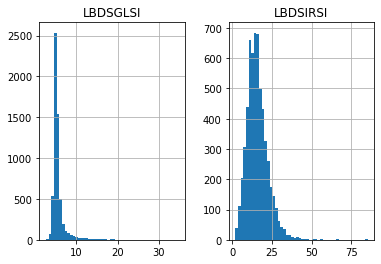

In [32]:
bio.hist(['LBDSGLSI','LBDSIRSI'],bins=50)

There is also a built-in method for generating kernel density plots, and multiple types of graphs can be plotted at the same time. The plotting methods take an `ax` argument that specifies which `matplotlib.Axes` object the data should be plotted on.

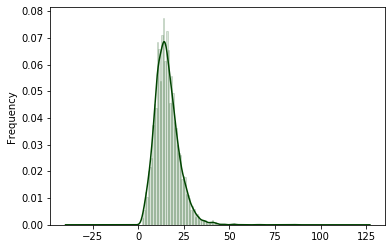

In [33]:
ax = bio['LBDSIRSI'].plot.kde(c='#004400')
bio['LBDSIRSI'].plot.hist(ax=ax,bins=100,density=True,alpha=0.15,color='#004400',ec='#00440022')

## Merging dataframes and selecting subframes

The NHANES data track individuals by `SEQN` across the various files. With `pandas` it is easy for us to load in these multiple files and make sure that all the data are associated with the correct individual. First, let's load in the datasets into their own dataframes, and take a look at them.

In [34]:
bio = pd.read_sas('BIOPRO_J.XPT',index='SEQN')
demo = pd.read_sas('DEMO_J.XPT',index='SEQN')
bmx = pd.read_sas('BMX_J.XPT',index='SEQN')
diet = pd.read_sas('DR1TOT_J.XPT',index='SEQN')
bp = pd.read_sas('BPX_J.XPT',index='SEQN')

print(bio.columns,demo.columns,bmx.columns,diet.columns)

Index(['LBXSATSI', 'LBDSATLC', 'LBXSAL', 'LBDSALSI', 'LBXSAPSI', 'LBXSASSI',
       'LBXSC3SI', 'LBXSBU', 'LBDSBUSI', 'LBXSCLSI', 'LBXSCK', 'LBXSCR',
       'LBDSCRSI', 'LBXSGB', 'LBDSGBSI', 'LBXSGL', 'LBDSGLSI', 'LBXSGTSI',
       'LBDSGTLC', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSOSSI', 'LBXSPH',
       'LBDSPHSI', 'LBXSKSI', 'LBXSNASI', 'LBXSTB', 'LBDSTBSI', 'LBDSTBLC',
       'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSTP', 'LBDSTPSI',
       'LBXSTR', 'LBDSTRSI', 'LBXSUA', 'LBDSUASI'],
      dtype='object') Index(['SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDRETH1',
       'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC', 'DMDBORN4',
       'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL', 'RIDEXPRG',
       'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP',
       'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ', 'DMDFMSIZ',
       'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ',
       

In [35]:
demo.describe()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
count,9254.0,9254.000000,9254.000000,9.254000e+03,5.970000e+02,9254.000000,9254.000000,8704.000000,3.433000e+03,6004.000000,...,8764.000000,9063.000000,4751.000000,9254.000000,9.254000e+03,9254.000000,9254.000000,8763.000000,8780.000000,8.023000e+03
mean,10.0,1.940566,1.507564,3.433423e+01,1.043719e+01,3.233953,3.497190,1.517348,1.074757e+02,1.909394,...,2.050776,1.472691,2.110714,34670.706829,3.467071e+04,1.517614,140.965853,12.500057,12.202506,2.375490e+00
std,0.0,0.236448,0.499970,2.550028e+01,7.092970e+00,1.277650,1.700961,0.499728,7.061824e+01,0.318958,...,0.652806,0.721168,0.688517,41356.667327,4.334400e+04,0.499717,4.200801,17.307571,17.155294,1.600291e+00
min,10.0,1.000000,1.000000,5.397605e-79,5.397605e-79,1.000000,1.000000,1.000000,5.397605e-79,1.000000,...,1.000000,1.000000,1.000000,2571.068712,5.397605e-79,1.000000,134.000000,1.000000,1.000000,5.397605e-79
25%,10.0,2.000000,1.000000,1.100000e+01,4.000000e+00,3.000000,3.000000,1.000000,4.300000e+01,2.000000,...,2.000000,1.000000,2.000000,13074.433246,1.234731e+04,1.000000,137.000000,6.000000,6.000000,1.040000e+00
50%,10.0,2.000000,2.000000,3.100000e+01,1.000000e+01,3.000000,3.000000,2.000000,1.060000e+02,2.000000,...,2.000000,1.000000,2.000000,21098.454260,2.105989e+04,2.000000,141.000000,8.000000,8.000000,1.920000e+00
75%,10.0,2.000000,2.000000,5.800000e+01,1.700000e+01,4.000000,4.000000,2.000000,1.660000e+02,2.000000,...,2.000000,2.000000,3.000000,36923.316352,3.756200e+04,2.000000,145.000000,14.000000,14.000000,3.690000e+00
max,10.0,2.000000,2.000000,8.000000e+01,2.400000e+01,5.000000,7.000000,2.000000,2.390000e+02,9.000000,...,3.000000,3.000000,3.000000,433085.005262,4.197628e+05,2.000000,148.000000,99.000000,99.000000,5.000000e+00


In [36]:
bmx.describe()

,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,BMXBMI,BMXLEG,BMILEG,BMXARML,BMIARML,BMXARMC,BMIARMC,BMXWAIST,BMIWAIST,BMXHIP,BMIHIP
count,8704.000000,8580.000000,416.000000,894.000000,24.0,194.000000,0.0,8016.000000,99.000000,8005.000000,6703.000000,334.0,8177.000000,347.0,8173.000000,350.0,7601.000000,437.0,6039.000000,270.0
mean,1.135800,65.138508,3.002404,81.089262,1.0,40.932474,NaN,156.593401,2.353535,26.577502,38.643980,1.0,33.667996,1.0,29.193589,1.0,89.928851,1.0,105.281868,1.0
std,0.506137,32.890754,0.401796,14.485755,0.0,2.635062,NaN,22.257858,0.940182,8.260724,4.158013,0.0,7.229185,0.0,7.970648,0.0,22.805093,0.0,14.848187,0.0
min,1.000000,3.200000,1.000000,49.100000,1.0,32.400000,NaN,78.300000,1.000000,12.300000,24.800000,1.0,9.400000,1.0,11.200000,1.0,40.000000,1.0,66.600000,1.0
25%,1.000000,43.100000,3.000000,69.900000,1.0,38.925000,NaN,151.400000,1.000000,20.400000,35.800000,1.0,32.000000,1.0,23.800000,1.0,73.900000,1.0,95.200000,1.0
50%,1.000000,67.750000,3.000000,82.000000,1.0,41.050000,NaN,161.900000,3.000000,25.800000,38.800000,1.0,35.800000,1.0,30.100000,1.0,91.200000,1.0,103.100000,1.0
75%,1.000000,85.600000,3.000000,92.700000,1.0,42.700000,NaN,171.200000,3.000000,31.300000,41.500000,1.0,38.400000,1.0,34.700000,1.0,105.300000,1.0,112.700000,1.0
max,4.000000,242.600000,4.000000,111.300000,1.0,47.900000,NaN,197.700000,3.000000,86.200000,55.000000,1.0,49.900000,1.0,56.300000,1.0,169.500000,1.0,179.000000,1.0


One thing we can notice right away is that the different files do not have the exact same individuals. The `demo` table has at least 9254 entries not counting any potential `NaN` values, while the `bmx` table only has 8704. This means that there are at least 550 entries in `demo` that do not appear in `bmx` (and it could also be the case that some entries in `bmx` are not in `demo`). Meanwhile, we already know that the `bio` table has only 6401 entries.

When combining these dataframes together, it is important to make sure that all the data are associated with the correct `SEQN`, and that we handle cases when the columns have different numbers of rows. The [`Dataframe.merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) command makes this easy. If you have ever used an SQL-style database, this operation behaves like a database `JOIN`. Essentially the merge command, as we are using it, creates a single table that has all of the columns in the two tables that we merged.

We will first merge the `bio` data with the `demo` data. When we call `bio.merge(demo)`, `bio` is considered the "left" table and demo is considered the "right" table. The `on` argument tells what column is used as a reference key for determining which data values go together; the column must appear in both dataframes. We choose `SEQN` because that is the identifier shared between the tables. The `how` argument determines what rows are kept in the merge. The options are:

- 'left' keeps only the rows that appear in the left dataframe. Any rows in the right dataframe that don't match one of the entries in the `on` column are thrown out.
- 'right' is the opposite of left: it keeps only rows that appear in the right dataframe
- 'outer' keeps all rows, and fills in any missing column data with `NaN`. So if a row in the left table doesn't have a match in the right table, that row will be added to the right table and filled with `NaN`.
- 'inner' keeps only those rows that appear in both tables, and any rows that appear in only one table are discarded.

By default, the order of the keys in the left dataframe is preserved. Let's compare an inner join with an outer join. The inner join keeps only rows that appear in both dataframes. Since the `bio` frame only has 6401 entries, the maximum possible number of entries in the merged dataframe is 6401, if every `SEQN` value in `bio` has a match in `demo`.

In [37]:
df = bio.merge(demo,how='inner',on='SEQN')
df

,LBXSATSI,LBDSATLC,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,LBXSC3SI,LBXSBU,LBDSBUSI,LBXSCLSI,...,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,16.0,5.397605e-79,4.4,44.0,74.0,20.0,31.0,11.0,3.93,100.0,...,1.0,2.0,NaN,8614.571172,8338.419786,2.0,145.0,3.0,3.0,0.82
93706.0,10.0,5.397605e-79,4.4,44.0,79.0,14.0,28.0,12.0,4.28,104.0,...,3.0,1.0,2.0,8548.632619,8723.439814,2.0,134.0,NaN,NaN,NaN
93707.0,13.0,5.397605e-79,5.2,52.0,238.0,24.0,22.0,17.0,6.07,97.0,...,2.0,1.0,3.0,6769.344567,7064.609730,1.0,138.0,10.0,10.0,1.88
93708.0,19.0,5.397605e-79,3.9,39.0,66.0,21.0,27.0,16.0,5.71,104.0,...,1.0,1.0,1.0,13329.450589,14372.488765,2.0,138.0,6.0,6.0,1.63
93709.0,15.0,5.397605e-79,3.7,37.0,86.0,17.0,24.0,20.0,7.14,100.0,...,2.0,2.0,NaN,12043.388271,12277.556662,1.0,136.0,2.0,2.0,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,22.0,5.397605e-79,4.8,48.0,57.0,27.0,27.0,13.0,4.64,100.0,...,2.0,1.0,1.0,16896.276203,18338.711104,2.0,138.0,4.0,4.0,0.95
102953.0,40.0,5.397605e-79,4.0,40.0,115.0,29.0,24.0,17.0,6.07,106.0,...,2.0,2.0,NaN,61630.380013,63661.951573,2.0,137.0,12.0,12.0,NaN
102954.0,6.0,5.397605e-79,3.9,39.0,55.0,15.0,21.0,8.0,2.86,101.0,...,2.0,2.0,NaN,17160.895269,17694.783346,1.0,144.0,10.0,10.0,1.18


The merged dataframe has 6401 rows, so this does mean that every row in `bio` had a match in `demo`. The inner merge is therefore equivalent to a left merge, as we can show.

In [38]:
df = bio.merge(demo,how='left',on='SEQN')
df

,LBXSATSI,LBDSATLC,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,LBXSC3SI,LBXSBU,LBDSBUSI,LBXSCLSI,...,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,16.0,5.397605e-79,4.4,44.0,74.0,20.0,31.0,11.0,3.93,100.0,...,1.0,2.0,NaN,8614.571172,8338.419786,2.0,145.0,3.0,3.0,0.82
93706.0,10.0,5.397605e-79,4.4,44.0,79.0,14.0,28.0,12.0,4.28,104.0,...,3.0,1.0,2.0,8548.632619,8723.439814,2.0,134.0,NaN,NaN,NaN
93707.0,13.0,5.397605e-79,5.2,52.0,238.0,24.0,22.0,17.0,6.07,97.0,...,2.0,1.0,3.0,6769.344567,7064.609730,1.0,138.0,10.0,10.0,1.88
93708.0,19.0,5.397605e-79,3.9,39.0,66.0,21.0,27.0,16.0,5.71,104.0,...,1.0,1.0,1.0,13329.450589,14372.488765,2.0,138.0,6.0,6.0,1.63
93709.0,15.0,5.397605e-79,3.7,37.0,86.0,17.0,24.0,20.0,7.14,100.0,...,2.0,2.0,NaN,12043.388271,12277.556662,1.0,136.0,2.0,2.0,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,22.0,5.397605e-79,4.8,48.0,57.0,27.0,27.0,13.0,4.64,100.0,...,2.0,1.0,1.0,16896.276203,18338.711104,2.0,138.0,4.0,4.0,0.95
102953.0,40.0,5.397605e-79,4.0,40.0,115.0,29.0,24.0,17.0,6.07,106.0,...,2.0,2.0,NaN,61630.380013,63661.951573,2.0,137.0,12.0,12.0,NaN
102954.0,6.0,5.397605e-79,3.9,39.0,55.0,15.0,21.0,8.0,2.86,101.0,...,2.0,2.0,NaN,17160.895269,17694.783346,1.0,144.0,10.0,10.0,1.18


If instead we do an outer merge, we get a table that has a row for every entry in either dataframe, in this case yielding a total of 9254 rows.

In [39]:
df = bio.merge(demo,how='outer',on='SEQN')
df

,LBXSATSI,LBDSATLC,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,LBXSC3SI,LBXSBU,LBDSBUSI,LBXSCLSI,...,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,16.0,5.397605e-79,4.4,44.0,74.0,20.0,31.0,11.0,3.93,100.0,...,1.0,2.0,NaN,8614.571172,8.338420e+03,2.0,145.0,3.0,3.0,0.82
93706.0,10.0,5.397605e-79,4.4,44.0,79.0,14.0,28.0,12.0,4.28,104.0,...,3.0,1.0,2.0,8548.632619,8.723440e+03,2.0,134.0,NaN,NaN,NaN
93707.0,13.0,5.397605e-79,5.2,52.0,238.0,24.0,22.0,17.0,6.07,97.0,...,2.0,1.0,3.0,6769.344567,7.064610e+03,1.0,138.0,10.0,10.0,1.88
93708.0,19.0,5.397605e-79,3.9,39.0,66.0,21.0,27.0,16.0,5.71,104.0,...,1.0,1.0,1.0,13329.450589,1.437249e+04,2.0,138.0,6.0,6.0,1.63
93709.0,15.0,5.397605e-79,3.7,37.0,86.0,17.0,24.0,20.0,7.14,100.0,...,2.0,2.0,NaN,12043.388271,1.227756e+04,1.0,136.0,2.0,2.0,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,NaN,9558.457817,1.042875e+04,1.0,139.0,4.0,4.0,0.73
102940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,3.0,170302.804596,5.397605e-79,2.0,143.0,NaN,NaN,NaN
102942.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,NaN,14913.515411,1.557493e+04,1.0,147.0,7.0,7.0,2.46


You'll notice that the entries at the bottom of the table contain `NaN` for the 'LBX...' values. Becasue the order of keys in the left table is preserved, all the rows that only appeared in the right table are included at the end of the merged table. Since these didn't have any corrsponding entries in the left table, the columns from the left table are filled with `NaN`. We can visualize the order of the data by just plotting the `SEQN` value in the merged table. the first line are the entries that were originally in the left table, then what follow are the entries that didn't have matches in the left table.

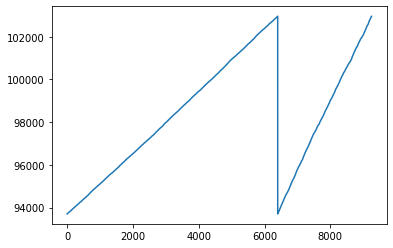

In [40]:
df = bio.merge(demo,how='outer',on='SEQN')
fig,ax = plt.subplots()
ax.plot(df.index)

Now we can merge together the other three dataframes to have one master frame with all of the data.

In [41]:
df = df.merge(bmx,how='outer',on='SEQN')
df = df.merge(diet,how='outer',on='SEQN')
df = df.merge(bp,how='outer',on='SEQN')
df

,LBXSATSI,LBDSATLC,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,LBXSC3SI,LBXSBU,LBDSBUSI,LBXSCLSI,...,BPAEN1,BPXSY2,BPXDI2,BPAEN2,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,16.0,5.397605e-79,4.4,44.0,74.0,20.0,31.0,11.0,3.93,100.0,...,NaN,NaN,NaN,NaN,202.0,62.0,2.0,198.0,74.0,2.0
93706.0,10.0,5.397605e-79,4.4,44.0,79.0,14.0,28.0,12.0,4.28,104.0,...,2.0,114.0,70.0,2.0,108.0,76.0,2.0,NaN,NaN,NaN
93707.0,13.0,5.397605e-79,5.2,52.0,238.0,24.0,22.0,17.0,6.07,97.0,...,2.0,128.0,46.0,2.0,128.0,58.0,2.0,NaN,NaN,NaN
93708.0,19.0,5.397605e-79,3.9,39.0,66.0,21.0,27.0,16.0,5.71,104.0,...,NaN,138.0,78.0,2.0,144.0,76.0,2.0,144.0,74.0,2.0
93709.0,15.0,5.397605e-79,3.7,37.0,86.0,17.0,24.0,20.0,7.14,100.0,...,2.0,118.0,66.0,2.0,118.0,68.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102942.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With this master dataset, we can compare data across different categores. For instance, we can make a chart of height vs age. From consulting the NHANES documentation ([DEMO_J](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm), [BMX_J](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BMX_J.htm)), we can see that the key for age in years is `RIDAGEYR` and for height in cm `BMXHT`.

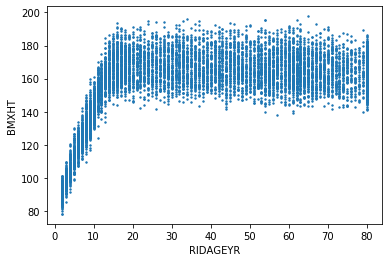

In [42]:
df.plot.scatter(x='RIDAGEYR',y='BMXHT',s=2)

Often with a dataset like this you would like to select a subset to work with. For instance, let's say we want to look at the heights of adults between the ages of 18 and 65.  Using [boolean indexing](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html#boolean-indexing) we can create subtables where one or more conditions is/are true. the resulting table can be used for further visualization or analysis.

In [43]:
df[df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(65)]

,LBXSATSI,LBDSATLC,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,LBXSC3SI,LBXSBU,LBDSBUSI,LBXSCLSI,...,BPAEN1,BPXSY2,BPXDI2,BPAEN2,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4
SEQN,,,,,,,,,,,,,,,,,,,,,
93706.0,10.0,5.397605e-79,4.4,44.0,79.0,14.0,28.0,12.0,4.28,104.0,...,2.0,114.0,70.0,2.0,108.0,76.0,2.0,NaN,NaN,NaN
93711.0,20.0,5.397605e-79,4.0,40.0,56.0,23.0,29.0,14.0,5.00,102.0,...,2.0,94.0,68.0,2.0,102.0,64.0,2.0,NaN,NaN,NaN
93712.0,46.0,5.397605e-79,4.8,48.0,99.0,35.0,31.0,14.0,5.00,98.0,...,2.0,116.0,72.0,2.0,112.0,70.0,2.0,NaN,NaN,NaN
93714.0,22.0,5.397605e-79,3.4,34.0,72.0,16.0,32.0,11.0,3.93,100.0,...,NaN,NaN,NaN,NaN,164.0,94.0,2.0,160.0,72.0,2.0
93716.0,27.0,5.397605e-79,4.1,41.0,56.0,20.0,24.0,18.0,6.43,102.0,...,2.0,120.0,74.0,2.0,122.0,70.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102717.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


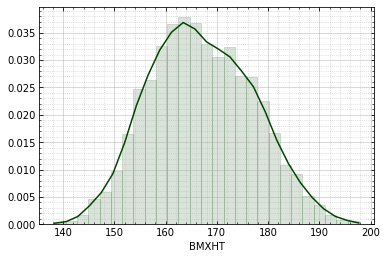

In [44]:
fig,ax = plt.subplots()
make_hist_kde(ax, df[df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(65)].BMXHT.dropna())

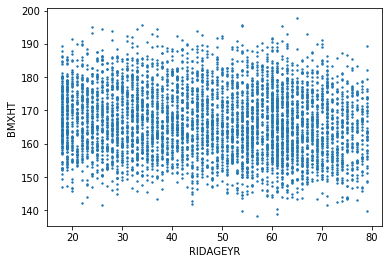

In [45]:
htage = df[df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(79)].loc[:,['BMXHT','RIDAGEYR']]
htage.plot.scatter(x='RIDAGEYR',y='BMXHT',s=2)

In [46]:
htage.describe()

,BMXHT,RIDAGEYR
count,5086.000000,5429.000000
mean,166.598152,47.517591
std,10.034777,17.416130
min,138.300000,18.000000
25%,159.100000,32.000000
50%,166.100000,48.000000
75%,173.900000,62.000000
max,197.700000,79.000000


Before moving on, it is important to understand how the boolean indexing above works so that you know how to make selections correctly. When setting a condition, `pandas` returns a boolean series containing `True` and `False` values to indicate the result of the test. Rows with `True` are retained when using the condition as an index, and rows with `False` are dropped.

We can look at the result of the first condition:

In [47]:
df.RIDAGEYR.ge(18)

SEQN
93705.0      True
93706.0      True
93707.0     False
93708.0      True
93709.0      True
            ...  
102939.0    False
102940.0     True
102942.0    False
102950.0     True
102951.0    False
Name: RIDAGEYR, Length: 9254, dtype: bool

This series tells whether the subject's age is >= 18. The second condition is age <= 65. To show both tests at the same time, we can create a new dataframe that merges both of these boolean series together:

In [48]:
pd.DataFrame(df.RIDAGEYR.ge(18)).merge(df.RIDAGEYR.le(65),on='SEQN',how='outer')

,RIDAGEYR_x,RIDAGEYR_y
SEQN,,
93705.0,True,False
93706.0,True,True
93707.0,False,True
93708.0,True,False
93709.0,True,False
...,...,...
102939.0,False,True
102940.0,True,False
102942.0,False,True


Our goal was to get only the rows where both tests are true. We did this with the bitwise "and" operator `&`. When applied to `numpy.ndarray` or `pandas.Series` objects, the operator does an element-by-element logical "AND" operation, which returns true only if both arguments are true. It's this result that we used to select the final rows that appeared in the final dataframe.

In [49]:
df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(65)

SEQN
93705.0     False
93706.0      True
93707.0     False
93708.0     False
93709.0     False
            ...  
102939.0    False
102940.0    False
102942.0    False
102950.0     True
102951.0    False
Name: RIDAGEYR, Length: 9254, dtype: bool

## Categorical data

When data in a column can only be one of a limited number of values, it is often useful to represent them as categorical data rather than numeric or string data. In our current dataset, much of the demographic data, including gender and race, are coded as numbers that represent categories. For instance, [gender (`RIAGENDR`)](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm#RIAGENDR) is coded as 1 for male and 2 for female, and in the current dataset those are the only two categories. The column [`RIDRETH3`](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm#RIDRETH3) codes for race/ethnicity using values 1-7. Since the numbers themselves don't have any meaning, it is more useful to tell `pandas` that the numbers represent categories of data. This will allow for more meaningful grouping of data, and enables some plotting methods to automatically generate graphs or perform analysis broken down by category if desired. In `pandas`, this is done using the [`pandas.Categorical`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html) datatype. A more complete [overview](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) of categorical data is also available in the `pandas` User Guide.

We'll set up categorical data for the `RIAGENDR` and `RIDRETH3` columns. First, we will tell `pandas` that we want to convert the RIAGENDR column to cateforical data using the [`Series.astype`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.astype.html) function.

In [50]:
df.RIAGENDR.astype('category')

SEQN
93705.0     2.0
93706.0     1.0
93707.0     1.0
93708.0     2.0
93709.0     2.0
           ... 
102939.0    2.0
102940.0    2.0
102942.0    2.0
102950.0    1.0
102951.0    1.0
Name: RIAGENDR, Length: 9254, dtype: category
Categories (2, float64): [1.0, 2.0]

This returns a new version of the column, where it recognizes that there are 2 categories: 1.0 and 2.0. Note however that it does not modify the original dataframe:

In [51]:
df.RIAGENDR.dtype

dtype('float64')

Next we want to tell `pandas` what the categories mean. We can use [`Series.cat.rename_categories`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.rename_categories.html) to accomplish this, just passing the new category names.

In [52]:
gendercat = df.RIAGENDR.astype('category')
gendercat = gendercat.cat.rename_categories(['Male','Female'])
gendercat

SEQN
93705.0     Female
93706.0       Male
93707.0       Male
93708.0     Female
93709.0     Female
             ...  
102939.0    Female
102940.0    Female
102942.0    Female
102950.0      Male
102951.0      Male
Name: RIAGENDR, Length: 9254, dtype: category
Categories (2, object): [Male, Female]

Now that we've configured the categories we like, we can reassign the `RIAGENDR` column with the categorical series.

In [53]:
df['RIAGENDR'] = gendercat
df.RIAGENDR

SEQN
93705.0     Female
93706.0       Male
93707.0       Male
93708.0     Female
93709.0     Female
             ...  
102939.0    Female
102940.0    Female
102942.0    Female
102950.0      Male
102951.0      Male
Name: RIAGENDR, Length: 9254, dtype: category
Categories (2, object): [Male, Female]

Let's do the same with the `RIDRETH3` column.

In [54]:
eth = df.RIDRETH3.astype('category')
eth = eth.cat.rename_categories(['Mexican American','Other Hispanic','Non-Hispanic White','Non-Hispanic Black','Non-Hispanic Asian','Other'])
df['RIDRETH3'] = eth
df.RIDRETH3

SEQN
93705.0     Non-Hispanic Black
93706.0     Non-Hispanic Asian
93707.0                  Other
93708.0     Non-Hispanic Asian
93709.0     Non-Hispanic Black
                   ...        
102939.0                 Other
102940.0    Non-Hispanic White
102942.0    Non-Hispanic White
102950.0    Non-Hispanic Black
102951.0    Non-Hispanic White
Name: RIDRETH3, Length: 9254, dtype: category
Categories (6, object): [Mexican American, Other Hispanic, Non-Hispanic White, Non-Hispanic Black, Non-Hispanic Asian, Other]

With the category data in place, we can easily generate plots of height broken down by category. First up, some [box plots](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html), which show the median, 25% and 75%iles (the box), the data range (the whiskers by default cover 1.5*(Q3-Q1)) and some outlier data. The `by` argument breaks down the data by value, which is especially convenient for categorical columns. Here we can plot the heights of people ages 18-65 broken down by gender or race/ethnicity.

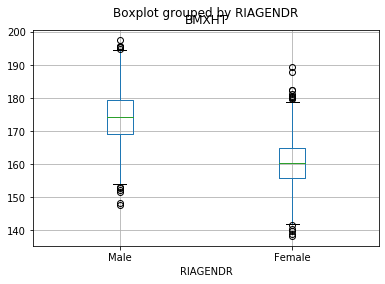

In [55]:
df[df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(65)].boxplot(column='BMXHT',by='RIAGENDR')

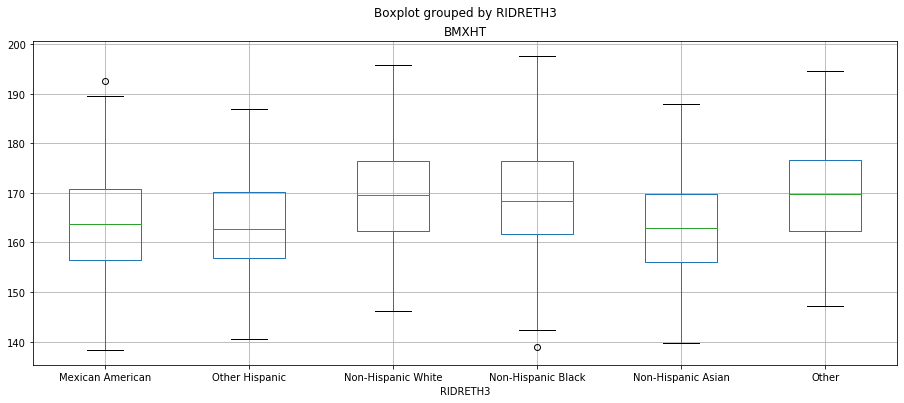

In [56]:
df[df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(65)].boxplot(column='BMXHT',by='RIDRETH3',figsize=(15,6))

The `by` argument to a histogram plot by default generates a separate plot for each category, but using the [`DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function we can make a view of the dataframe broken down by category. We then pull out the `BMXHT` column and create the histogram, which shows the two categories plotted on the same axis.

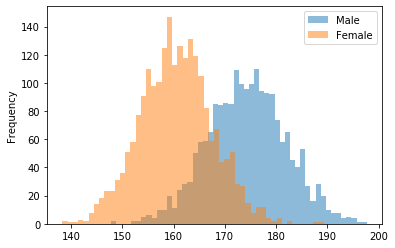

In [57]:
df[df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(65)].groupby('RIAGENDR').BMXHT.plot.hist(bins=50,alpha=0.5)
plt.legend()

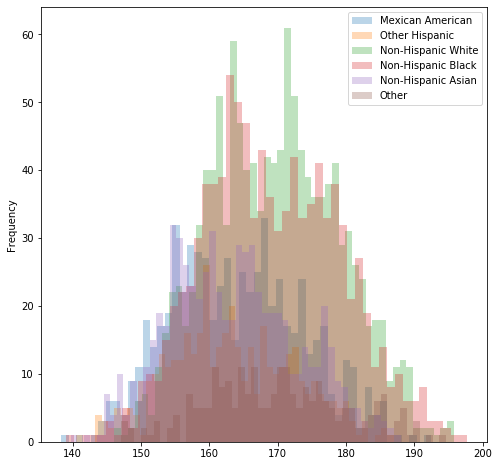

In [58]:
df[df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(65)].groupby('RIDRETH3').BMXHT.plot.hist(bins=50,alpha=0.3,figsize=(8,8))
plt.legend()

The `groupby` function can also take multiple columns, creating further breakdowns in the data. The plot below is hard to read, and would need further tweaking to be presentable, but hopefully this gives you an idea of the capabilities.

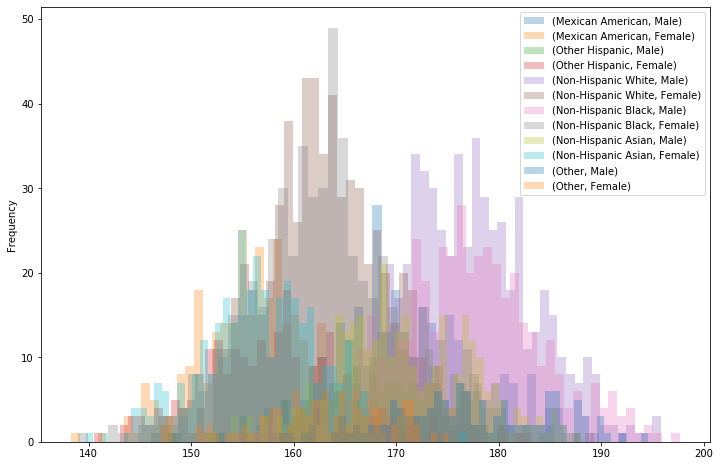

In [59]:
df[df.RIDAGEYR.ge(18) & df.RIDAGEYR.le(65)].groupby(['RIDRETH3','RIAGENDR']).BMXHT.plot.hist(bins=50,alpha=0.3,figsize=(12,8))
plt.legend()

## Reading/writing DataFrames

Since we have done the work to load in multiple data files and set up categories, we should save the dataframe we're working with to disk. In the next notebook, we'll pick up where we left off by reading in this file.

There are many ways to export dataframes. If you want to open them in Excel later, exporting as csv with [`DataFrame.to_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) is one option, or you can write directly to excel using [`DataFrame.to_excel`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html). Each file format has advantages and limitations; for instance, if we wtire to a csv file and read it back in, the columns we set as categorical will not be loaded in as categorical (the csv file doesn't have a way to record the type of the column, so when it is read, `pandas` just has to read the data in as strings or numbers). Perhaps the file format that provides the best mix of high efficiency, fast access, full-features storage, and ease of loading is HDF5, which can be written with [`DataFrame.to_hdf`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_hdf.html) and read with [`pandas.read_hdf`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_hdf.html).

To store the `df` dataframe to a file, we call `to_hdf`, giving it a filename, a key, and telling it to use the "table" format. HDF5 files can store multiple objects, and the key is used to identify the object in the file. We could store several dataframes if we wished, we would just need to add `append=True` to the arguments for subsequent `to_hdf` calls and give each object its own key.

When we later read the data, we just need to tell `pandas.read_hdf` the filename and the key we want to read, as shown below.

In [60]:
df.to_hdf('nhanes.hd5',key='df',format='table')
df2 = pd.read_hdf('nhanes.hd5','df')
df2.RIAGENDR

SEQN
93705.0     Female
93706.0       Male
93707.0       Male
93708.0     Female
93709.0     Female
             ...  
102939.0    Female
102940.0    Female
102942.0    Female
102950.0      Male
102951.0      Male
Name: RIAGENDR, Length: 9254, dtype: category
Categories (2, object): [Male, Female]